# Deep Learning with TensorFlow

Machine learning frameworks like TensorFlow, PaddlePaddle, Torch, Caffe, Keras, and many others can speed up our machine learning development significantly. Programing frameworks can not only shorten our coding time, but sometimes also perform optimizations that speed up the code. 

In this notebook, we will build a standard L-layer deep neural network from scratch using TensorFlow.

The network consists of L layers (including the input layer). The last layer uses softmax activation, while the others use ReLU activation.

The training dataset is split into **mini batches**, which seeks to find a balance between stochastic gradient descent and batch gradient descent. 

Xavier **initialization** method is used.

Two **regularization** techniques are implemented: inverted dropout and L2 regularization.

Two **optimization** algorithms are applied: gradient descent and Adam.

The constructed model is then applied to "Sign Language" project as an illustration.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
import h5py

plt.rcParams['figure.figsize'] = (6.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray' # set colormap

# Part I: Build Deep Neural Network

## 1. Introduction

We are going to build a tensorflow model using a softmax output. 

**The model** is *LINEAR -> RELU -> LINEAR -> RELU ...-> LINEAR -> SOFTMAX*. A SOFTMAX layer generalizes SIGMOID to when there are more than two classes. 

**Note**:
- Tensorflow is a programming framework used in deep learning
- The two main object classes in tensorflow are **Tensors and Operators**. 
- When we code in tensorflow we have to take the following steps:
    - Create a graph containing Tensors (Variables, Placeholders ...) and Operations (tf.matmul, tf.add, ...)
    - Create a session
    - Initialize the session
    - Run the session to execute the graph
- We can execute the graph multiple times
- The backpropagation and optimization is automatically done when running the session on the "optimizer" object.

## 2. Create Placeholders for Data

Create placeholders for `X` and `Y`. This will allow us to later pass our training data in when we run our session. 

A placeholder is an object whose value we can specify only later. 

To specify values for a placeholder, we can pass in values by using a "feed dictionary" (`feed_dict` variable). This allows us to pass in a number later when we run the session. We say that we **feed data** to these placeholders when running the session. 

Here's what's happening: When we specify the operations needed for a computation, we are telling TensorFlow how to construct a computation graph. The computation graph can have some placeholders whose values we will specify only later. Finally, when we run the session, we are telling TensorFlow to execute the computation graph.

In [2]:
def create_data_placeholders(n_x, n_y):
    """
    Create placeholders for the data
    
    Arguments:
    n_x: scalar, number of the input features
    n_y: scalar, number of the output classes
    
    Returns:
    X: placeholder for the input data, with the shape [n_x, None] and dtype 'float'
    Y: placeholder for the input labels, with the shape [n_y, None] and dtype 'float'
    
    Note that we use None in the shape because it lets us be flexible on the number of examples.
    """
    
    X = tf.placeholder(tf.float32, shape = [n_x, None])
    Y = tf.placeholder(tf.float32, shape = [n_y, None])
    
    return X, Y

## 3. Split Data into Mini Batches

In [3]:
# create mini batches randomly, each with the size of mini_batch_size.

def random_mini_batches(X, Y, mini_batch_size, seed = 0):
    """    
    Argument:
    X: input features, with dimension of (number of features, number of training examples)
    Y: true labels, the actual y values, with the dimension of (1, number of training examples)
    mini_batch_size: size of each mini batch.
    seed: random seed
    
    Returns:
    mini_batches: list of (mini_batch_X, mini_batch_Y)
    """
        
    np.random.seed(seed)
    
    m = X.shape[1] # total number of examples
    mini_batches = []
    
    # for batch gradient descent, no need to shuffle
    if mini_batch_size == X.shape[1]:
        mini_batch = (X, Y)
        mini_batches.append(mini_batch)
        return mini_batches
    
    # Step 1: shuffle
    permutation_indices = list(np.random.permutation(m))
    shuffled_X = X[:, permutation_indices]
    shuffled_Y = Y[:, permutation_indices]
    
    # Step 2: partition
    num_batch_except_last = math.floor(m / mini_batch_size)
    for i in range(num_batch_except_last):
        mini_batch_X = shuffled_X[:, i * mini_batch_size:(i + 1) * mini_batch_size - 1]
        mini_batch_Y = shuffled_Y[:, i * mini_batch_size:(i + 1) * mini_batch_size - 1]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    # last mini batch
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_batch_except_last * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_batch_except_last * mini_batch_size:]
        mini_batches.append((mini_batch_X, mini_batch_Y))
        
    return mini_batches

## 4. Initialize the Parameters

Initialize the parameters, i.e., the weight matrices W and bias vectors b.

We use Xavier Initialization for weights and Zero Initialization for biases.

In [4]:
# initialize parameters: weight matrices and bias vectors for each layer

def init_params(layer_dims, initialization, seed = 0):
    """
    Arguments: 
    layer_dims: python array, layer_dims[l] is the number of units in the lth layer. 
                l = 0 is the input layer, the last l is the output layer.
    initialization: choose which initialization to use: 
                "xavier": Xavier initialization
    seed: random seed
    
    Returns:
    params: a dictionary of tensors containing weight matrices wl and bias vectors bl for the lth layer, 
            params['W1'], params['W2'], ..., params['Wl'], ..., and params['b1'], params['b2'], ..., params['bl'], ... 
            Wl has the dimension of (layer_dims[l], layer_dims[l - 1])
            bl has the dimension of (layer_dims[l], 1)
            
    Use random initialization for the weight matrices, and use zero initialization for the biases.
    """
    
    params = {}
    L = len(layer_dims) # total number of layers, including the input layer. 
    
    # set the graph-level seed.
    tf.set_random_seed(seed)
    
    for l in range(1, L):
        if initialization == "xavier":
            params['W' + str(l)] = tf.get_variable('W' + str(l), shape = (layer_dims[l], layer_dims[l-1]), 
                                                   initializer = tf.contrib.layers.xavier_initializer(seed = seed))
            params['b' + str(l)] = tf.get_variable('b' + str(l), shape = (layer_dims[l], 1), 
                                                   initializer = tf.zeros_initializer())
    
    return params      

## 5. Forward Propagation

### 5.1 Without Dropout

We now implement the forward propagation module in tensorflow. The function takes in a dictionary of parameters and completes the forward pass. 

It is important to note that the forward propagation stops at `z[L]`. The reason is that in tensorflow the last linear layer output is given as input to the function computing the loss. Therefore, we don't need `a[L]`!

In [5]:
# whole forward propagation of L-layer deep neural network, without dropout
# The output is z[L] rather than a[L]

def L_layer_forward(X, params):
    """
    Arguments:
    X: input features placeholder, with dimension of (number of features, number of examples)
    params: a dictionary of tensors containing weight matrices wl and bias vectors bl for the lth layer, 
            params['W1'], params['W2'], ..., params['Wl'], ..., and params['b1'], params['b2'], ..., params['bl'], ... 
            Wl has the dimension of (layer_dims[l], layer_dims[l - 1])
            bl has the dimension of (layer_dims[l], 1)
    
    Returns:
    Zout: the linear output of the last layer, with the shape (number of classes, number of examples)
    """
    
    L = len(params) // 2 + 1 # total number of layers including the input layer
    
    A_prev = X
    
    # relu activation for the layers except the last one
    for l in range(1, L - 1):
        W = params['W' + str(l)]
        b = params['b' + str(l)]
        Z = tf.add(tf.matmul(W, A_prev), b)
        A = tf.nn.relu(Z)
        A_prev = A
        
    # linear output for the last layer
    W = params['W' + str(L - 1)]
    b = params['b' + str(L - 1)]
    Zout = tf.add(tf.matmul(W, A_prev), b)
   
    return Zout

### 5.2 With Inverted Dropout

In [6]:
# whole forward propagation of L-layer deep neural network, with inverted dropout
# The output is z[L] rather than a[L]

def L_layer_forward_inverted_dropout(X, params, drop_rate):
    """
    Arguments:
    X: input features placeholder, with dimension of (number of features, number of examples)
    params: a dictionary of tensors containing weight matrices wl and bias vectors bl for the lth layer, 
            params['W1'], params['W2'], ..., params['Wl'], ..., and params['b1'], params['b2'], ..., params['bl'], ... 
            Wl has the dimension of (layer_dims[l], layer_dims[l - 1])
            bl has the dimension of (layer_dims[l], 1)
    drop_rate: A scalar Tensor. The probability that each element is discarded.
    
    Returns:
    Zout: the linear output of the last layer, with the shape (number of classes, number of examples)
    """
    
    L = len(params) // 2 + 1 # total number of layers including the input layer
    
    A_prev = X
    
    # relu activation for the layers except the last one
    for l in range(1, L - 1):
        W = params['W' + str(l)]
        b = params['b' + str(l)]
        Z = tf.add(tf.matmul(W, A_prev), b)
        A = tf.nn.relu(Z)
        # add dropout
        A = tf.nn.dropout(A, rate = drop_rate)
        A_prev = A
        
    # linear output for the last layer
    W = params['W' + str(L - 1)]
    b = params['b' + str(L - 1)]
    Zout = tf.add(tf.matmul(W, A_prev), b)
   
    return Zout

## 6. Calculate Cost

### 6.1 Cross Entropy Cost

Compute the cross entropy cost.

**Note**:
- It is important to know that the "`logits`" and "`labels`" inputs of `tf.nn.softmax_cross_entropy_with_logits_v2` are expected to be of shape (number of examples, number of classes). Thus We have to transpose Zout and Y.
- The returned shape of `tf.nn.softmax_cross_entropy_with_logits_v2` is the same as labels except that it does not have the last dimension of labels. `tf.reduce_mean` basically does the mean over the examples.

In [7]:
# calculate the cross-entropy cost function

def cost_func(Zout, Y):
    """
    Arguments:
    Zout: the linear output of the last layer, with the shape (number of classes, number of examples)
    Y: true labels placeholder, the actual y values, with the dimension of (number of classes, number of examples)
    
    Returns:
    cost: the cross-entropy cost tensor
    """
    
    # transpose to shape (number of examples, number of classes) to meet tensorflow requirement.
    logits = tf.transpose(Zout)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = labels, logits = logits))
    
    return cost

### 6.2 L2 Regularization

In [8]:
# calculate the cost function with L2 regularization

def cost_func_L2_regul(Zout, Y, lambd, params, m):
    """
    Arguments:
    Zout: the linear output of the last layer, with the shape (number of classes, number of examples)
    Y: true labels placeholder, the actual y values, with the dimension of (number of classes, number of examples)
    params: a dictionary of tensors containing weight matrices wl and bias vectors bl for the lth layer, 
            params['W1'], params['W2'], ..., params['Wl'], ..., and params['b1'], params['b2'], ..., params['bl'], ... 
    lambd: the lambda parameter for L2 regularization
    m: number of examples
    
    Returns:
    cost: the cross-entropy cost tensor, with L2 regularization term
    """
    
    L = len(params) // 2 + 1
    
    cross_entropy_cost = cost_func(Zout, Y)
    regularizer = 0
    for l in range(1, L):
        regularizer += tf.nn.l2_loss(params['W' + str(l)])
    regularizer *= lambd / m
    
    cost = cross_entropy_cost + regularizer
    
    return cost

## 7. Backward Propagation

This is where we become grateful to programming frameworks. All the backpropagation and the parameters update is taken care of in 1 line of code. It is very easy to incorporate this line in the model.

After we compute the cost function, we create an "`optimizer`" object. We have to call this object along with the cost when running the tf.session. When called, it will perform an optimization on the given cost with the chosen method and learning rate.

For instance, for gradient descent the optimizer would be:
```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
```

To make the optimization we would do:
```python
_ , c = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
```

This computes the backpropagation by passing through the tensorflow graph in the reverse order, from cost to inputs.

**Note**: when coding, we often use `_` as a "throwaway" variable to store values that we won't need to use later. Here, `_` takes on the evaluated value of `optimizer`, which we don't need (and `c` takes the value of the `cost` variable). 

## 8. Complete Model

Writing and running programs in TensorFlow has the following steps:

1. Create Tensors (variables) that are not yet executed/evaluated. 
2. Write operations between those Tensors.
3. Initialize our Tensors. 
4. Create a Session. 
5. Run the Session. This will run the operations we have written above. 

When we create a variable for the cost, we simply define the cost as a function of other quantities, but have not evaluated its value. To evaluate it, we have to run `init=tf.global_variables_initializer()`, which initializes the cost variable.

**remember to initialize our variables, create a session and run the operations inside the session**. 

Note that there are **two typical ways to create and use sessions in tensorflow**: 

**Method 1:**
```python
sess = tf.Session()
# Run the variables initialization (if needed), run the operations
result = sess.run(..., feed_dict = {...})
sess.close() # Close the session
```
**Method 2:**
```python
with tf.Session() as sess: 
    # run the variables initialization (if needed), run the operations
    result = sess.run(..., feed_dict = {...})
    # This takes care of closing the session
```    

In [9]:
# Build the L-layer deep neural network model

def L_layer_model(train_X, train_Y, test_X, test_Y, layer_dims, params_seed = 0, mini_batch_size = None, 
                  optimizer = "adam", learning_rate = 0.0001, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, 
                  epochs = 1500, print_cost_freq = 0, save_cost_freq = 100, initialization = "xavier", 
                  regularization = "none", lambd = 0, drop_rate = 0):
    """
    Arguments:
    train_X: training set features, with the dimension of (number of features, number of training examples)
    train_Y: training set labels, with the dimension of (number of classes, number of training examples)
    test_X: training set features, with the dimension of (number of features, number of test examples)
    test_Y: training set labels, with the dimension of (number of classes, number of test examples)
    layer_dims: python array, layer_dims[l] is the number of units in the lth layer. 
                l = 0 is the input layer, the last l is the output layer (i.e., number of classes)
    params_seed: random seed for parameter initialization.
    mini_batch_size: size of each mini batch. By default it is the total number of examples, i.e., batch gradient descent
    optimizer: choose the optimization method:
               "gd": gradient descent
               "adam": Adam optimization
    learning_rate: learning rate for gradient descent
    beta1, beta2: hyperparameters for Adam optimization
    epsilon: hyperparameter preventing division by zero in Adam updates
    epochs: number of epochs
    print_cost_freq: if > 0, print the cost value every print_cost_freq epochs.
    save_cost_freq: save the cost value every save_cost_freq epochs into costs, for ploting the learning curve.
    initialization: choose which initialization to use: 
                "xavier": Xavier initialization
    regularization: choose the regularization method:
                "none": no regularization
                "L2": L2 regularization
    lambd: the lambda parameter for L2 regularization
    drop_rate: parameter for inverted dropout,the probability of dropping a neuron. If it's 0, dropout is not used.
    
    Returns:
    params: python dictionary containing weight matrix wl and bias vector bl for the lth layer, 
            params['W1'], params['W2'], ..., params['Wl'], ..., and params['b1'], params['b2'], ..., params['bl'], ... 
            Wl has the dimension of (layer_dims[l], layer_dims[l - 1]).
            bl has the dimension of (layer_dims[l], 1)
            
    """
    assert(drop_rate <= 1 and drop_rate >= 0)
    
    ops.reset_default_graph() # to be able to rerun the model without overwriting tf variables
    
    costs = []
    tf.set_random_seed(1)
    minibatch_seed = 3 # random seed for creating mini batches
    m = train_X.shape[1] # number of training examples
    if mini_batch_size is None:
        mini_batch_size = m
    num_mini_batches = math.ceil(m / mini_batch_size) # number of mini batches
        
    # create placeholders for data
    n_x = train_X.shape[0]
    n_y = train_Y.shape[0]
    X, Y = create_data_placeholders(n_x, n_y)
    
    # initialization
    params = init_params(layer_dims, initialization, params_seed)
    
    # forward propagation:
    if drop_rate > 0:
        drop_rate_placeholder = tf.placeholder("float")
        Zout = L_layer_forward_inverted_dropout(X, params, drop_rate_placeholder)
    else:
        Zout = L_layer_forward(X, params) 
    
    # calculate the cost
    if regularization == "L2":
        cost = cost_func_L2_regul(Zout, Y, lambd, params, mini_batch_size)
    else:
        cost = cost_func(Zout, Y)
    
    # backward propagation: define the tensorflow optimizer
    if optimizer == "gd":
        opt = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    if optimizer == "adam":
        opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1, beta2 = beta2, 
                                     epsilon = epsilon).minimize(cost)
        
    # initialize all variables
    init = tf.global_variables_initializer()

    # start a session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # run initializer
        sess.run(init)
        
        for i in range(1, epochs + 1):
            # define a cost related to an epoch, as the average cost over all mini batches within a single epoch
            epoch_cost = 0 
            # create mini batches
            minibatch_seed += 1
            mini_batches = random_mini_batches(train_X, train_Y, mini_batch_size, minibatch_seed)
            for mini_batch in mini_batches:
                (mini_batch_X, mini_batch_Y) = mini_batch
                # run the graph on a mini batch
                # run the session to excute the optimizer and the cost.
                if drop_rate > 0:
                    _, mini_batch_cost = sess.run([opt, cost], feed_dict = {X : mini_batch_X, Y : mini_batch_Y, 
                                                                            drop_rate_placeholder : drop_rate})
                else:
                    _, mini_batch_cost = sess.run([opt, cost], feed_dict = {X : mini_batch_X, Y : mini_batch_Y})
                epoch_cost += mini_batch_cost / num_mini_batches
            # print and save the costs
            if print_cost_freq > 0 and (i == 1 or i % print_cost_freq == 0):
                print("current epoch: " + str(i) + ", cost: " + str(epoch_cost))
            if save_cost_freq > 0 and (i == 1 or i % save_cost_freq == 0):
                costs.append(epoch_cost)
         
        # plot the cost
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('epochs * ' + str(save_cost_freq))
        plt.title('learning rate = ' + str(learning_rate))
        plt.show()

        # save the parameters
        params = sess.run(params)
        print('Parameters have been trained!')
        
        # evaluate the model accuracy
        
        # do not use dropout for testing
        Zout = L_layer_forward(X, params)
        
        # Get the correct predictions
        # for each example (i.e., each column), the maximum Zout corresponds to the predicted class
        correct_pred = tf.equal(tf.argmax(Zout, axis = 0), tf.argmax(Y, axis = 0)) # shape is (number of examples,)
        
        # calculate the accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_pred, "float"))
        
        print("Training Set Accuracy: " + str(accuracy.eval({X : train_X, Y : train_Y})))
        print("Test Set Accuracy: " + str(accuracy.eval({X : test_X, Y : test_Y})))
        
    return params

In [10]:
# make predictions based on trained parameters and input X

def predict(params, X):
    """
    Arguments: 
    X: input features, with the dimension of (number of features, number of examples)
    params: trained weight matrices and bias vectors of the neural network
    
    Returns:
    predicted labels for X, with the dimension of (1, number of examples)
    """
    
    L = len(params) // 2 + 1 # number of layers including the input layer   
    x = tf.placeholder("float")
    for l in range(1, L):
        params['W' + str(l)] = tf.convert_to_tensor(params['W' + str(l)])
        params['b' + str(l)] = tf.convert_to_tensor(params['b' + str(l)])
    Zout = L_layer_forward(x, params)
    Y_pred = tf.argmax(Zout, axis = 0)
    
    with tf.Session() as sess:
        Y_pred = sess.run(Y_pred, feed_dict = {x : X})
    Y_pred = Y_pred.reshape(1, X.shape[1])
    
    return Y_pred

# Part II: Example - Sign Language

## 1. Introduction

One afternoon, we decided to teach our computers to decipher sign language. We spent a few hours taking pictures in front of a white wall and came up with the following dataset： 

- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Here are examples for each number, and how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels.

<img src="images/hands.png" style="width:800px;height:350px;">

Our goal is to build an algorithm that would facilitate communications from a speech-impaired person to someone who doesn't understand sign language.

## 2. Load Data

In [11]:
# load training and test data, and list of classes

def load_data():
    """
    Returns:
    train_x_orig: numpy array, original training set features 
    train_y_orig: numpy array, original training set labels 
    test_x_orig: numpy array, original test set features 
    test_y_orig: numpy array, original test set labels 
    classes: numpy array, list of classes  
    """
    # training set
    train_data = h5py.File('data/train_signs.h5', 'r')
    train_x_orig = np.array(train_data['train_set_x']) # training set features
    train_y_orig = np.array(train_data['train_set_y']) # training set labels
    # test set
    test_data = h5py.File('data/test_signs.h5', 'r')
    test_x_orig = np.array(test_data['test_set_x']) # test set features
    test_y_orig = np.array(test_data['test_set_y']) # test set labels
    # list of classes
    classes = np.array(test_data['list_classes'])
    # reshape the labels, make sure the dimension is (1, number of examples)
    train_y_orig = train_y_orig.reshape((1, train_y_orig.shape[0]))
    test_y_orig = test_y_orig.reshape((1, test_y_orig.shape[0]))
    
    return train_x_orig, train_y_orig, test_x_orig, test_y_orig, classes    

In [12]:
# load the data
train_x_orig, train_y_orig, test_x_orig, test_y_orig, classes = load_data()
print("Total number of training examples: " + str(train_x_orig.shape[0]))
print("Total number of test examples: " + str(test_x_orig.shape[0]))
print("Size of each image: " + str(train_x_orig[0].shape))
print("All classes: " + str(classes))
print("train_x_orig shape: " + str(train_x_orig.shape))
print("train_y_orig shape: " + str(train_y_orig.shape))
print("test_x_orig shape: " + str(test_x_orig.shape))
print("test_y_orig shape: " + str(test_y_orig.shape))

Total number of training examples: 1080
Total number of test examples: 120
Size of each image: (64, 64, 3)
All classes: [0 1 2 3 4 5]
train_x_orig shape: (1080, 64, 64, 3)
train_y_orig shape: (1, 1080)
test_x_orig shape: (120, 64, 64, 3)
test_y_orig shape: (1, 120)


In [13]:
# show some examples of the images in the training set

def example(indices, X, Y, classes):
    """
    Arguments:
    indices: list of the indices of X to be shown
    X: image fearues, with the shape of (number of examples, num_px, num_px, 3)
    Y: image classes, with the shape of (1, number of examples)
    classes: numpy array, list of classes
    """
    
    num = len(indices)
    columns = 5 # the number of columns to arrange the figures
    plt.figure(figsize = (20, 12))
    
    for i in range(num):
        plt.subplot(math.ceil(num / columns), columns, i + 1)
        plt.imshow(X[indices[i]])
        plt.axis('off')
        plt.title("Index = " + str(indices[i]) + ", class: " + str(classes[Y[0, indices[i]]]))

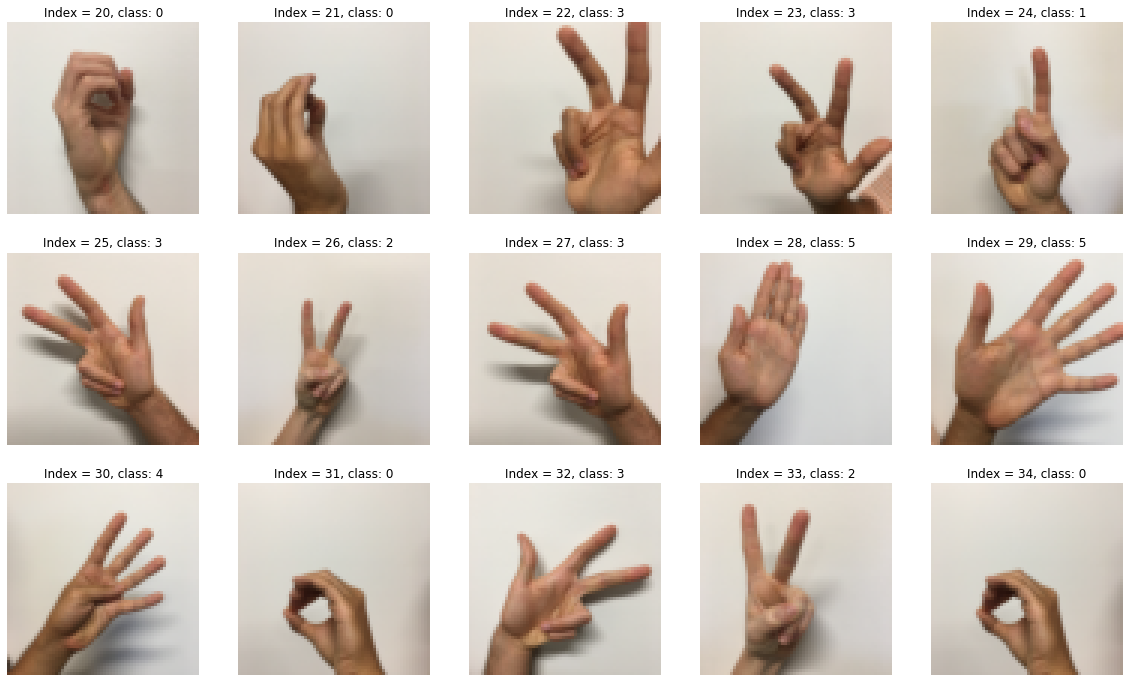

In [14]:
indices = [i for i in range(20, 35, 1)]
example(indices, train_x_orig, train_y_orig, classes)

## 3. Data Pre-Processing

We flatten the image dataset, then normalize it by dividing by 255. On top of that, we convert each label to a one-hot vector.

**One Hot Encoding:**

Many times in deep learning we will have a y vector with numbers ranging from 0 to C-1, where C is the number of classes. If C is for example 4, then we might have the following y vector which we will need to convert as follows:

<img src="images/onehot.png" style="width:600px;height:150px;">

This is called a "one hot" encoding, because in the converted representation exactly one element of each column is "hot" (meaning set to 1). In tensorflow, we can use one line of code: 

- tf.one_hot(labels, depth, axis) 

In [15]:
# convert Y to one-hot vectors

def convert_to_one_hot(Y, C):
    """
    Argument:
    Y: labels, with the dimension of (1, number of examples)
    C: number of classes
    
    Returns:
    Y_converted: one-hot representation of Y, with the dimension of (C, number of examples)
    """
    
    # numpy.eye() returns a 2-D array with ones on the diagonal and zeros elsewhere.
    # note that its ith column is exactly the one-hot representation of the ith class 
    Y_converted = np.eye(C)[:, Y.reshape(-1)]
    
    return Y_converted

In [16]:
# pre-processing the features

# convert image features from (num_px, num_px, 3) to 1-D vector:
train_x = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# standardize, so the values are between 0 and 1.
train_x = train_x / 255
test_x = test_x / 255

# convert labels to one-hot vectors
train_y = convert_to_one_hot(train_y_orig, len(classes))
test_y = convert_to_one_hot(test_y_orig, len(classes))


print("dimension of train_x: " + str(train_x.shape))
print("dimension of test_x: " + str(test_x.shape))
print("dimension of train_y: " + str(train_y.shape))
print("dimension of test_y: " + str(test_y.shape))

dimension of train_x: (12288, 1080)
dimension of test_x: (12288, 120)
dimension of train_y: (6, 1080)
dimension of test_y: (6, 120)


## 4. Model Training and Evaluation

current epoch: 1, cost: 2.583696786095114
current epoch: 5000, cost: 0.6109305024147034
current epoch: 10000, cost: 0.5843909838620354
current epoch: 15000, cost: 0.5493054793161506
current epoch: 20000, cost: 0.542342079036376
current epoch: 25000, cost: 0.5303607758353738


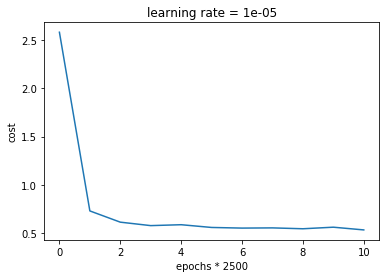

Parameters have been trained!
Training Set Accuracy: 1.0
Test Set Accuracy: 0.89166665


In [18]:
layer_dims = [train_x.shape[0], 25, 12, len(classes)]

params = L_layer_model(train_x, train_y, test_x, test_y, layer_dims, params_seed = 1, mini_batch_size = 32, 
                       optimizer = "adam", learning_rate = 0.00001, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, 
                       epochs = 25000, print_cost_freq = 5000, save_cost_freq = 2500, initialization = "xavier", 
                       regularization = "L2", lambd = 0.7, drop_rate = 0.1) 

## 5. Result Analysis

In [19]:
# show some mislabeled images

def mislabeled_example(X, Y, predicted_Y, classes, max_examples):
    """
    Arguments:
    X: input features, numpy array of shape (number of features, number of examples)
    Y: true labels
    predicted_Y: predicted labels
    max_examples: maximum number of examples to be shown
    """
    columns = 5 # number of columns to arrange the figures
    plt.figure(figsize = (20, 12))
    
    mislabeled_indices = np.asarray(np.where(Y != predicted_Y))
    
    num = min(len(mislabeled_indices[1, :]), max_examples) # determine the number of examples to be shown
    
    for i in range(num):
        plt.subplot(math.ceil(num / columns), columns, i + 1)
        plt.imshow(X[:, mislabeled_indices[1, i]].reshape(64, 64, 3))
        plt.axis('off')
        plt.title("predicted class: " + str(classes[int(predicted_Y[0, mislabeled_indices[1, i]])]) + 
                 "\n actual class: " + str(classes[int(Y[0, mislabeled_indices[1, i]])]))    

In [20]:
predicted_Y = predict(params, train_x)
mislabeled_example(train_x, train_y_orig, predicted_Y, classes, 11)

<Figure size 1440x864 with 0 Axes>

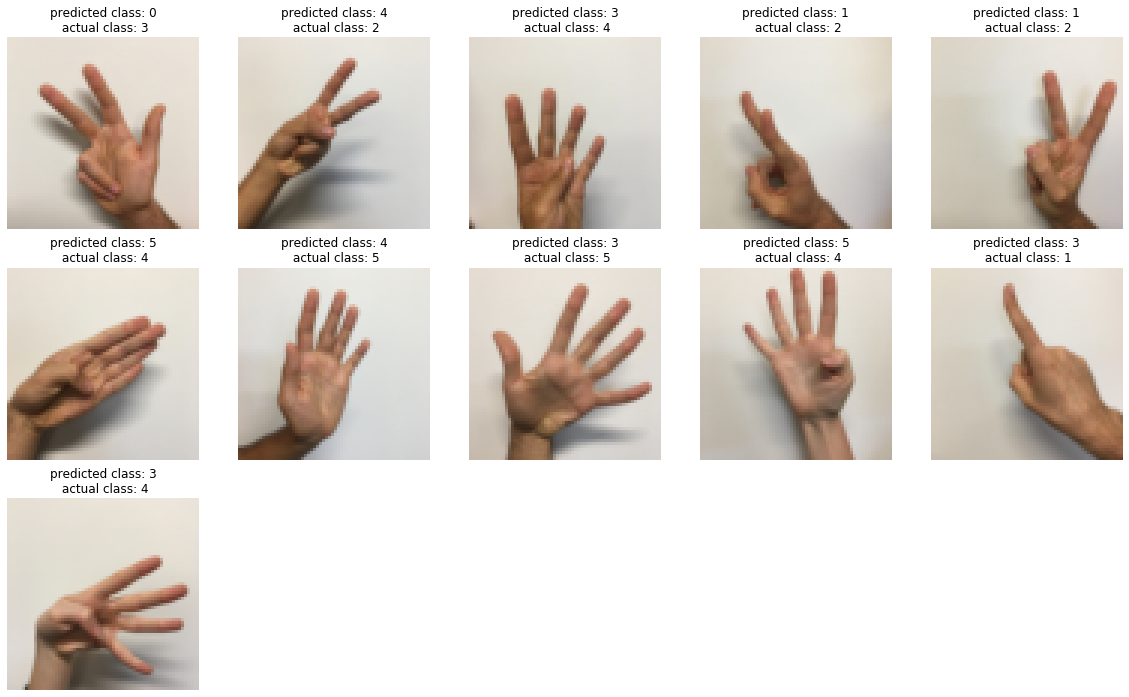

In [21]:
predicted_Y = predict(params, test_x)
mislabeled_example(test_x, test_y_orig, predicted_Y, classes, 11)